In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
import os
import tensorflow as tf


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [332]:
train_df = pd.read_csv("covid19-global-forecasting-week-2/train.csv", index_col=0)
test_df = pd.read_csv("covid19-global-forecasting-week-2/test.csv")

In [333]:
train_df.head()

,Country_Region,Province_State,Date,ConfirmedCases,Fatalities
Id,,,,,
1,Afghanistan,NaN,2020-01-22,0.0,0.0
2,Afghanistan,NaN,2020-01-23,0.0,0.0
3,Afghanistan,NaN,2020-01-24,0.0,0.0
4,Afghanistan,NaN,2020-01-25,0.0,0.0
5,Afghanistan,NaN,2020-01-26,0.0,0.0


In [334]:
train_df.loc[train_df['Country_Region'].isna(), 'Country_Region'] = ''
train_df.loc[train_df['Province_State'].isna(), 'Province_State'] = ''
train_df['region'] = train_df['Country_Region'] + ' ' + train_df['Province_State']
test_df.loc[test_df['Country_Region'].isna(), 'Country_Region'] = ''
test_df.loc[test_df['Province_State'].isna(), 'Province_State'] = ''
test_df['region'] = test_df['Country_Region'] + ' ' + test_df['Province_State']

In [335]:
covid_data = pd.read_csv('./covid_dataset.csv')
covid_data.loc[covid_data['Province/State'].isna(), 'Province/State'] = ''
covid_data.loc[covid_data['Country/Region'].isna(), 'Country/Region'] = ''

In [336]:
covid_data['region'] = covid_data['Country/Region'] + ' ' + covid_data['Province/State']

In [337]:
covid_data.drop(axis=1, columns=['lat', 'long', 'Country/Region', 'Province/State', 'day', 'temperature', 'humidity', 'confirmed', 'deaths', 'recovered'], inplace=True)

In [338]:
data_world = covid_data.groupby(['region']).first()

In [339]:
train_df = pd.merge(train_df, data_world, how='left', on=['region'])

In [340]:
train_df.drop(axis=1, columns=['Country_Region', 'Province_State', 'ConfirmedCases'], inplace=True)

In [341]:
train_df.shape

(18816, 15)

In [342]:
train_df = train_df.groupby(['region', 'Date']).sum()

In [343]:
data_min = train_df.min(axis=0)
data_max = train_df.max(axis=0)
train_df = (train_df - data_min) / (data_max - data_min)

In [344]:
train_df

Fatalities       pop  urbanpop  density  medianage  \
region       Date                                                             
Afghanistan  2020-01-22    0.000000  0.027046  0.011086  0.03874   0.965812   
             2020-01-23    0.000000  0.027046  0.011086  0.03874   0.965812   
             2020-01-24    0.000000  0.027046  0.011086  0.03874   0.965812   
             2020-01-25    0.000000  0.027046  0.011086  0.03874   0.965812   
             2020-01-26    0.000000  0.027046  0.011086  0.03874   0.965812   
...                             ...       ...       ...      ...        ...   
Zimbabwe     2020-03-21    0.000000  0.011485  0.000000  0.00000   0.000000   
             2020-03-22    0.000000  0.011485  0.000000  0.00000   0.000000   
             2020-03-23    0.000133  0.011485  0.000000  0.00000   0.000000   
             2020-03-24    0.000133  0.011485  0.000000  0.00000   0.000000   
             2020-03-25    0.000133  0.011485  0.000000  0.00000   0.000000   

                         smokers  tests  testpop  health_exp_pc  hospibed  \
region       Date                                                           
Afghanistan  2020-01-22      0.0    0.0      0.0       0.006111  0.986329   
             2020-01-23      0.0    0.0      0.0       0.006111  0.986329   
             2020-01-24      0.0    0.0      0.0       0.006111  0.986329   
             2020-01-25      0.0    0.0      0.0       0.006111  0.986329   
             2020-01-26      0.0    0.0      0.0       0.006111  0.986329   
...                          ...    ...      ...            ...       ...   
Zimbabwe     2020-03-21      0.0    0.0      0.0       0.009574  0.000000   
             2020-03-22      0.0    0.0      0.0       0.009574  0.000000   
             2020-03-23      0.0    0.0      0.0       0.009574  0.000000   
             2020-03-24      0.0    0.0      0.0       0.009574  0.000000   
             2020-03-25      0.0    0.0      0.0       0.009574  0.000000   

                         quarantine  schools  restrictions  
region       Date                                           
Afghanistan  2020-01-22         0.0      0.0           0.0  
             2020-01-23         0.0      0.0           0.0  
             2020-01-24         0.0      0.0           0.0  
             2020-01-25         0.0      0.0           0.0  
             2020-01-26         0.0      0.0           0.0  
...                             ...      ...           ...  
Zimbabwe     2020-03-21         0.0      0.0           0.0  
             2020-03-22         0.0      0.0           0.0  
             2020-03-23         0.0      0.0           0.0  
             2020-03-24         0.0      0.0           0.0  
             2020-03-25         0.0      0.0           0.0  

[18816 rows x 13 columns]

In [345]:
## iterate through each country and construct time series data
random.seed(1)

def multivariate_data(dataset, target, 
                      start_index, end_index, 
                      history_size, target_size, 
                      step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return data, labels

def create_time_series_data(dataset, history_data=14, STEP=1, split_ratio=0.2, target_column=0):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for country in dataset.index.get_level_values('region').unique():
        country_data = dataset.loc[country].values

        data, label = multivariate_data(country_data, country_data[:,target_column],
                                        0, None, history_data, 7, STEP)

        idx_test = random.sample(range(len(data)), int(len(data)*split_ratio))
        idx_train = [idx for idx in range(len(data)) if idx not in idx_test]

        X_test.extend([data[idx] for idx in idx_test])
        y_test.extend([label[idx] for idx in idx_test])
        X_train.extend([data[idx] for idx in idx_train])
        y_train.extend([label[idx] for idx in idx_train])

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    
    return X_train, y_train, X_test, y_test

In [346]:
X_train, y_train, X_test, y_test = create_time_series_data(train_df, target_column=0)

(10290, 14, 13)
(10290, 7)
(2352, 14, 13)
(2352, 7)


In [347]:
BATCH_SIZE = 100
BUFFER_SIZE = 10000
train_data_multi = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
test_data_multi = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data_multi = test_data_multi.batch(BATCH_SIZE).repeat()

In [348]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=X_train.shape[-2:]))
model.add(tf.keras.layers.LSTM(16, activation='relu'))
model.add(tf.keras.layers.Dense(7))

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')

In [349]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 14, 32)            5888      
_________________________________________________________________
lstm_13 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 119       
Total params: 9,143
Trainable params: 9,143
Non-trainable params: 0
_________________________________________________________________


In [350]:
history = model.fit(train_data_multi, steps_per_epoch=200, 
                              validation_data=test_data_multi,
                              validation_steps=50, epochs=50)

Train for 200 steps, validate for 50 steps
Epoch 1/50
200/200 [==============================] - 8s 40ms/step - loss: 0.0055 - val_loss: 0.0016
Epoch 2/50
200/200 [==============================] - 5s 23ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 3/50
200/200 [==============================] - 6s 28ms/step - loss: 8.5790e-04 - val_loss: 9.4926e-04
Epoch 4/50
200/200 [==============================] - 5s 24ms/step - loss: 8.3664e-04 - val_loss: 9.0399e-04
Epoch 5/50
200/200 [==============================] - 5s 23ms/step - loss: 8.9300e-04 - val_loss: 8.7593e-04
Epoch 6/50
200/200 [==============================] - 5s 24ms/step - loss: 8.3448e-04 - val_loss: 8.6812e-04
Epoch 7/50
200/200 [==============================] - 4s 22ms/step - loss: 7.8204e-04 - val_loss: 8.6051e-04
Epoch 8/50
200/200 [==============================] - 5s 23ms/step - loss: 8.7328e-04 - val_loss: 8.6521e-04
Epoch 9/50
200/200 [==============================] - 4s 21ms/step - loss: 7.4786e-04 - val_loss: 8.5

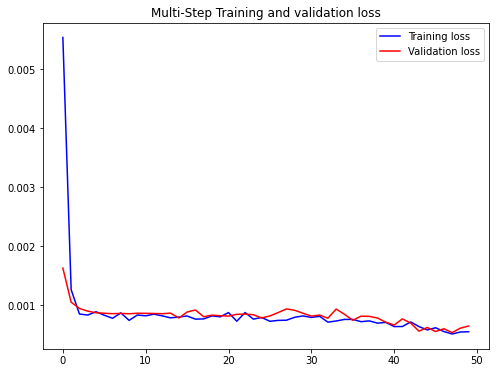

In [351]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    
    
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

plot_train_history(history, 'Multi-Step Training and validation loss')

In [352]:
def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction, STEP=1):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, -3]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()


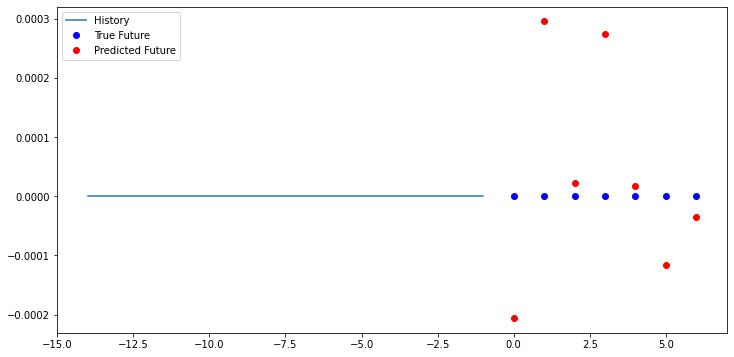

In [353]:
confirmed_model = model
for x, y in test_data_multi.shuffle(2000).take(1):
    multi_step_plot(x[0], y[0], confirmed_model.predict(x)[0])

In [320]:
df_pred_confirmed = pd.DataFrame()
for country in train_df.index.get_level_values('region').unique():
    country_data = train_df.loc[country].values
    data = country_data[-14:, ]

    output_data = data[-7:,0].tolist()
    for i in range(6):
        input_data = data[-14:, ]
        output_data.extend(confirmed_model.predict(input_data.reshape(1, 14, 13)).tolist()[0])
        data = np.append(data, data[-7:, ], axis=0)
        data[-7:,0] = output_data[-7:]
        i+=1

    df = pd.DataFrame({'region':country, 'Date':pd.date_range(start='2020-03-19', end='2020-05-06'), 'confirmed':output_data})
    df_pred_confirmed = pd.concat([df_pred_confirmed, df], ignore_index=True)

In [323]:
df_pred_confirmed.loc[df_pred_confirmed['confirmed']<0, 'confirmed'] = -df_pred_confirmed.loc[df_pred_confirmed['confirmed']<0, 'confirmed']
df_pred_confirmed['confirmed'] = df_pred_confirmed['confirmed'] * (data_max['ConfirmedCases'] - data_min['ConfirmedCases']) + data_min['ConfirmedCases']

In [325]:
test_df.Date=pd.to_datetime(test_df.Date)

In [326]:
df_submit = pd.merge(test_df, df_pred_confirmed, how='left', on=['region','Date'])

In [327]:
df_submit

,ForecastId,Country_Region,Province_State,Date,region,confirmed
0,1,Afghanistan,,2020-03-19,Afghanistan,22.000000
1,2,Afghanistan,,2020-03-20,Afghanistan,24.000000
2,3,Afghanistan,,2020-03-21,Afghanistan,24.000000
3,4,Afghanistan,,2020-03-22,Afghanistan,40.000000
4,5,Afghanistan,,2020-03-23,Afghanistan,40.000000
...,...,...,...,...,...,...
12637,12638,Zimbabwe,,2020-04-26,Zimbabwe,13.445479
12638,12639,Zimbabwe,,2020-04-27,Zimbabwe,1.174526
12639,12640,Zimbabwe,,2020-04-28,Zimbabwe,4.498376
12640,12641,Zimbabwe,,2020-04-29,Zimbabwe,7.156616


In [358]:
df_pred_fatalities = pd.DataFrame()
for country in train_df.index.get_level_values('region').unique():
    country_data = train_df.loc[country].values
    data = country_data[-14:, ]

    output_data = data[-7:,0].tolist()
    for i in range(6):
        input_data = data[-14:, ]
        output_data.extend(model.predict(input_data.reshape(1, 14, 13)).tolist()[0])
        data = np.append(data, data[-7:, ], axis=0)
        data[-7:,0] = output_data[-7:]
        i+=1
    
    df = pd.DataFrame({'region':country, 'Date':pd.date_range(start='2020-03-19', end='2020-05-06'), 'fatalities':output_data})
    df_pred_fatalities = pd.concat([df_pred_fatalities, df], ignore_index=True)

In [359]:
df_pred_fatalities.loc[df_pred_fatalities['fatalities']<0, 'fatalities'] = -df_pred_fatalities.loc[df_pred_fatalities['fatalities']<0, 'fatalities']
df_pred_fatalities['fatalities'] = df_pred_fatalities['fatalities'] * (data_max['Fatalities'] - data_min['Fatalities']) + data_min['Fatalities']


In [360]:
df_submit = pd.merge(df_submit, df_pred_fatalities, how='left', on=['region','Date'])

In [361]:
df_submit.confirmed = df_submit.confirmed.round()
df_submit.fatalities = df_submit.fatalities.round()
df_submit.fillna(0, inplace=True)

In [362]:
df_submit.to_csv('subm.csv', index=False, columns=['ForecastId', 'confirmed', 'fatalities'], header=['ForecastId','ConfirmedCases','Fatalities'])